In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
% pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
rootdir = '/Users/shuang/Documents/Proj_Radiomics/Data/her2'
outcome_fname = '{}/her2_ClinicalData/her2_outcome_NJupdated.csv'.format(rootdir)
her2_outcome_df = pd.read_csv(outcome_fname,dtype={'MRN': str,'Recurrence Type Summary': str,'Brith Date': str, 'Date at Dx': str, 'Date Recurrence': str, 'Vital status': str})
her2_outcome_df = her2_outcome_df.replace('#VALUE!',np.nan)
# print her2_outcome_df.dtypes
print(her2_outcome_df.shape)
print(her2_outcome_df['Recurrence Type Summary'].value_counts())

(121, 53)
NONE/DISEASE FREE            67
NEVER DISEASE FREE           13
RECURRED, TYPE UNKNOWN        4
UNKNOWN                       4
DIST RECUR, BONE              4
DIST RECUR, SYSTEMIC          2
DIST RECUR MULTIPLE SITES     1
DIST RECUR, LUNG              1
DIST RECUR, CNS               1
LOCAL RECUR, INVAS TUMOR      1
DIST RECUR, LYMPH NODE        1
Name: Recurrence Type Summary, dtype: int64


#### The below definition was [here](https://www.researchgate.net/post/Are_there_differences_between_progression-free_survival_relapse-free_survival_and_recurrence-free_survival2)

Recurrence-free survival (RFS) includes the following:
- any recurrence (local or regional, including invasive ipsilateral tumor and invasive locoregional tumor, or distant) - death due to any cause (both BC and non-BC causes of death).
Note that under STEEP DFS (disease-free survival) is interchangeable with recurrence-free survival

Relapse-free survival:
- as any disease recurrence (local, regional, or distant)
- death is censored (not included)

In [5]:
# convert data to appropriate date
her2_outcome_df['Date_Recur'] = pd.to_datetime(her2_outcome_df['Date Recurrence'])
her2_outcome_df['Date_Dx'] = pd.to_datetime(her2_outcome_df['Date of Primary Dx'])
her2_outcome_df['Date_lastcontactOrDeath'] = pd.to_datetime(her2_outcome_df['Last contact/death'])
# print type(her2_outcome_df.ix[1,'Date_Recur'])
# # print her2_outcome_df['Date_Dx']
# # print her2_outcome_df['Date_lastcontactOrDeath']

def duration_func(x):
#     print 'Recurrence = {}'.format(x['Recurrence'])
#     print 'Dx: {}, Recur: {}, last contact: {}'.format(x['Date_Dx'], x['Date_Recur'], x['Date_lastcontactOrDeath'])
    if x['Recurrence'] == 1:
        if isinstance(x['Date_Dx'], pd.tslib.NaTType) is False and isinstance(x['Date_Recur'], pd.tslib.NaTType) is False:
            delta_time = (x['Date_Recur'] - x['Date_Dx']).days
            return delta_time
        else:
            return np.nan
    elif x['Recurrence'] == 0:
        if isinstance(x['Date_Dx'], pd.tslib.NaTType) is False and isinstance(x['Date_lastcontactOrDeath'], pd.tslib.NaTType) is False:
            delta_time = (x['Date_lastcontactOrDeath'] - x['Date_Dx']).days
            return delta_time
        else:
            return np.nan
    else:
        return np.nan

def relapse_free_observed(x):
    rf_dur = x['relapse_free_duration']
    if np.isnan(rf_dur) == False:
        if x['Recurrence'] == 1:
            return 1
        elif x['Recurrence'] == 0 and x['Alive/dead'] == 1:
            return 0
        elif x['Recurrence'] == 0 and x['Alive/dead'] == 0:
            return 0
        elif x['Recurrence'] == 2:
            return np.nan
        else:
            return np.nan
    else:
        return np.nan
    
def recurrence_free_observed(x):
    rf_dur = x['relapse_free_duration']
    if np.isnan(rf_dur) == False:
        if x['Recurrence'] == 1:
            return 1
        elif x['Recurrence'] == 0 and x['Alive/dead'] == 1:
            return 0
        elif x['Recurrence'] == 0 and x['Alive/dead'] == 0:
            return 1
        elif x['Recurrence'] == 2:
            return np.nan
        else:
            return np.nan
    else:
        return np.nan
        
her2_outcome_df['relapse_free_duration'] = her2_outcome_df.apply(duration_func,axis=1)
# her2_outcome_df['relapse_observed'] = her2_outcome_df.apply(relapse_free_observed,axis=1)
her2_outcome_df['recurrence_observed'] = her2_outcome_df.apply(recurrence_free_observed,axis=1)
# print her2_outcome_df.ix[:,['Recurrence','relapse_free_duration','relapse_observed','Alive/dead']]

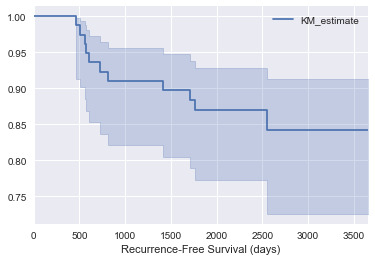

In [6]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
T = her2_outcome_df['relapse_free_duration'].dropna()
# E = her2_outcome_df['relapse_observed'].dropna()
E = her2_outcome_df['recurrence_observed'].dropna()
kmf.fit(T, event_observed=E)
kmf.plot()
# plt.xlabel('Relapse-Free Survival (years)')
plt.xlabel('Recurrence-Free Survival (days)')

In [7]:
# look at the survival curves for different subgroups

# get some more outcome data
# PET and MRI image setting
the_mri_tp = 2
the_mri_glcmbin = 128
the_pet_imgnorm_bin = 128
the_pet_glcmbin = 64

# get all the consensus clustering result and determine the BEST cluster result
im_dir = '{}/her2_Analysis/PETMRI/PETgbin{}_imgbin{}_MRItp{}_gbin{}'.format(rootdir,the_pet_glcmbin,the_pet_imgnorm_bin,the_mri_tp,the_mri_glcmbin)
df_data_all = pd.read_csv('{}/data_all.csv'.format(im_dir),dtype={'MRN': str})
df_data_all = df_data_all.rename(columns={'Sjoerd_Grade': 'Tumor_Grade', 'Marjan_Histology': 'Tumor_Histology'})
# print df_data_all.columns.tolist()
outcome_list = ['Recurrence_Type', 'Diseasefree_5yr', 'BoneMetsOrNot','Recurrence_3', 'Recurrence_4','TripleNeg',
                'Tumor_Grade','Tumor_Histology', 'T_stage', 'N_stage', 'Overall_stage','BC_subtype']
df_outcome = df_data_all.ix[:,['MRN','ptid_side'] + outcome_list]

# get CC cluster result for tumor grade
cc_prefix = 'patientConsensusCluster'
# the_cm = 'hc'
# the_cl = 'complete'
# the_dm = 'spearman'

the_cm = 'pam'
the_cl = None
the_dm = 'spearman'

if isinstance(the_cl, str):
    cc_dir = '{}/{}_{}_{}_{}'.format(im_dir, cc_prefix, the_cm, the_cl, the_dm)
else:
    cc_dir = '{}/{}_{}_{}'.format(im_dir, cc_prefix, the_cm, the_dm)
the_N_cluster = 3
cs_class_fname = '{}/ConsensusClass_kmax{}.csv'.format(cc_dir,the_N_cluster)
cs_class_df = pd.read_csv(cs_class_fname)
cs_class_df.columns = ['ptid_side', 'cs_class']

# combine the cs_class to the_df
jdf1 = pd.merge(df_outcome, cs_class_df, on='ptid_side')

# join with her2 recurrence data
jdf2 = pd.merge(jdf1,her2_outcome_df, on='MRN')
# print jdf2.ix[:,['MRN','relapse_free_duration','relapse_observed']]
# print jdf1.shape
# print jdf2.shape
# print her2_outcome_df.shape
# print df_data_all.shape

0.0    54
1.0     7
Name: recurrence_observed, dtype: int64


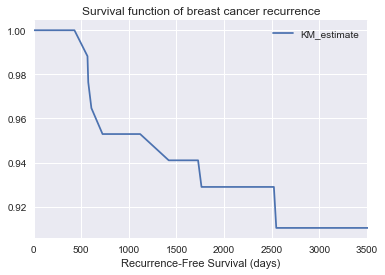

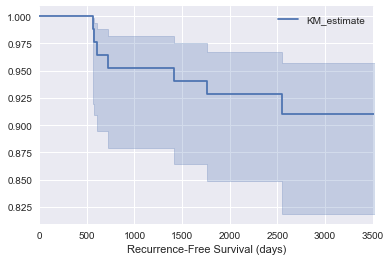

In [9]:
# survival analysis of N=86 (after joining with the image texture data)
kmf = KaplanMeierFitter()

T = jdf2['relapse_free_duration']
E = jdf2['recurrence_observed']
print(E.value_counts())
kmf.fit(T, event_observed=E)
kmf.survival_function_.plot()
plt.title('Survival function of breast cancer recurrence')
plt.xlabel('Recurrence-Free Survival (days)')
kmf.plot()
plt.xlabel('Recurrence-Free Survival (days)')

class 1, median survival time: inf
class 3, median survival time: inf
class 2, median survival time: inf


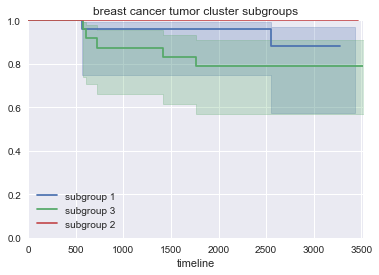

In [11]:
ax = plt.subplot(111)

the_subgroup_outcome = 'cs_class'
# the_subgroup_outcome = 'Tumor_Grade'
subgroup_list = jdf2[the_subgroup_outcome].unique().tolist()
for ii in subgroup_list:
    cc = (jdf2[the_subgroup_outcome] == ii)
    T2 = T[cc]
    E2 = E[cc]
    kmf.fit(T2, event_observed=E2, label='subgroup {}'.format(ii))
    kmf.plot(ax=ax)
    print('class {}, median survival time: {}'.format(ii,kmf.median_))
    
plt.ylim(0,1)
plt.title('breast cancer tumor cluster subgroups')

In [12]:
from lifelines.statistics import logrank_test
cc = (jdf2[the_subgroup_outcome] == 2)

results = logrank_test(T[cc],T[~cc],E[cc],E[~cc])
results.print_summary()

Results
   null distribution: chi squared
   df: 1
   alpha: 0.95
   test: logrank
   t 0: -1

   __ p-value ___|__ test statistic __|____ test result ____|__ is significant __
         0.04478 |              4.027 |      Reject Null    |        True       


(221, 2)
0    158
1     63
Name: rfs_ind, dtype: int64


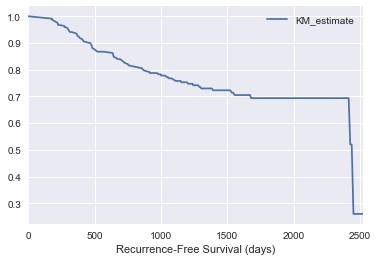

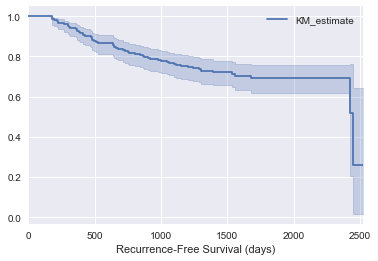

In [14]:
# test MRI ispy1 data
fname = '{}/mri_ispy1_RFS.csv'.format(im_dir)
df_ispy1 = pd.read_csv(fname)
T = df_ispy1['RFS']
E = df_ispy1['rfs_ind']
print(df_ispy1.shape)
print(df_ispy1['rfs_ind'].value_counts())
kmf.fit(T, event_observed=E)
kmf.survival_function_.plot()
plt.xlabel('Recurrence-Free Survival (days)')
kmf.plot()
plt.xlabel('Recurrence-Free Survival (days)')

In [33]:
# try cox regression model example
from lifelines import CoxPHFitter
import re

cph = CoxPHFitter()
# print(df_data_all.columns.tolist())
# print(her2_outcome.columns.tolist())

# select the needed variables
outcome_list = ['Recurrence_Type', 'Diseasefree_5yr', 'BoneMetsOrNot','Recurrence_3', 'Recurrence_4','TripleNeg',
                'Tumor_Grade','Tumor_Histology', 'T_stage', 'N_stage', 'Overall_stage','BC_subtype']
pat = re.compile('texture_|FOstats_|ShapeSize_')
feats_name = [ss for ss in df_data_all.columns.tolist() if pat.match(ss)]

df_feats = df_data_all.ix[:,['MRN'] + feats_name]

outcome_of_interest = ['MRN', 'relapse_free_duration', 'recurrence_observed']
df_outcome = her2_outcome_df.ix[:, outcome_of_interest]

# print(df_feats)
jdf3 = pd.merge(df_feats,df_outcome, on='MRN')
# print(jdf3.columns.tolist())

# drop redundant or unneeded columns
col_name_no_need = ['MRN','FOstats_uniformity_mri', 'texture_correlation_avg_mri', 'texture_energy_avg_mri',
                    'texture_idmn_avg_mri', 'texture_idn_avg_mri', 'texture_maxprob_avg_mri', 'texture_idmn_avg_pet']
jdf3 = jdf3.drop(col_name_no_need,axis=1)

cph.fit(jdf3, duration_col='relapse_free_duration', event_col='recurrence_observed')
cph.print_summary()  # access the results using cph.summary

# from lifelines.datasets import load_rossi
# rossi_dataset = load_rossi()
# print(rossi_dataset)
# cph = CoxPHFitter()
# cph.fit(rossi_dataset, duration_col='week', event_col='arrest')
# cph.print_summary()  # access the results using cph.summary

n=89, number of events=33

                                        coef  exp(coef)     se(coef)      z      p    lower 0.95   upper 0.95   
FOstats_energy_mri                    0.0000     1.0000       0.0000 0.0000 1.0000       -0.0000       0.0000   
FOstats_entropy_mri                   0.0000     1.0000       1.7599 0.0000 1.0000       -3.4500       3.4500   
FOstats_kurtosis_mri                  0.0000     1.0000       1.5263 0.0000 1.0000       -2.9922       2.9922   
FOstats_mean_mri                      0.0000     1.0000       0.0042 0.0000 1.0000       -0.0082       0.0082   
FOstats_skewness_mri                  0.0000     1.0000       3.9950 0.0000 1.0000       -7.8318       7.8318   
FOstats_variance_mri                  0.0000     1.0000       0.0000 0.0000 1.0000       -0.0000       0.0000   
ShapeSize_compactness1_mri            0.0000     1.0000      31.7833 0.0000 1.0000      -62.3078      62.3078   
ShapeSize_compactness2_mri            0.0000     1.0000      54.1181 

AssertionError: 